In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.eol_full_lstm import (
    build_full_eol_sequences_from_df,
    create_full_dataloaders,
    EOLFullLSTM,
    train_eol_full_lstm,
    evaluate_eol_full_lstm,
)


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Full-Trajectory LSTM für EOL-Prediction (FD001-FD004 - Separate Training)

Dieses Notebook trainiert für jedes CMAPSS-Dataset (FD001, FD002, FD003, FD004) **separat** ein LSTM-Modell für EOL-Prediction.

**Features:**
- Sliding-Window über alle Zyklen jeder Engine
- RUL wird auf max_rul=125 gecappt (NASA-Style)
- Engine-basierter Split (keine Data Leakage)
- NASA PHM08 Score Evaluation
- **Vergleichstabelle** aller Metriken am Ende


In [3]:
# ===================================================================
# Konfiguration: Datasets und Hyperparameter
# ===================================================================
FD_DATASETS = ["FD001", "FD002", "FD003", "FD004"]

# Training-Parameter (gleich für alle Datasets)
TRAINING_CONFIG = {
    "past_len": 30,
    "max_rul": 125,
    "batch_size": 256,
    "engine_train_ratio": 0.8,
    "num_epochs": 80,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "patience": 8,
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": False,
}

print("=" * 60)
print("Training Configuration")
print("=" * 60)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print("=" * 60)


Training Configuration
  past_len: 30
  max_rul: 125
  batch_size: 256
  engine_train_ratio: 0.8
  num_epochs: 80
  lr: 0.0001
  weight_decay: 0.0001
  patience: 8
  hidden_dim: 64
  num_layers: 2
  dropout: 0.1
  bidirectional: False


In [4]:
# ===================================================================
# Dictionary zum Speichern der Ergebnisse für jeden Dataset
# ===================================================================
results_dict = {}

for fd_id in FD_DATASETS:
    results_dict[fd_id] = {
        "model": None,
        "history": None,
        "metrics": None,
        "scaler": None,
        "num_engines": None,
        "num_samples": None,
    }


In [5]:
# ===================================================================
# Training-Loop: Jedes Dataset separat trainieren
# ===================================================================

for fd_id in FD_DATASETS:
    print("\n" + "=" * 80)
    print(f"Processing {fd_id}")
    print("=" * 80)
    
    # -------------------------------------------------------------------
    # 1. Daten laden
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 1: Loading data...")
    df_train, _, _ = load_cmapps_subset(
        fd_id,
        max_rul=None,  # Kein Clipping im Train (wird später in build_full_eol_sequences gecappt)
        clip_train=False,
        clip_test=True,  # Test weiter clampen für NASA-Score
    )
    df_train = create_physical_features(df_train)
    
    # FD_ID als numerisches Feature (für spätere Verwendung, falls nötig)
    fd_id_map = {"FD001": 0, "FD002": 1, "FD003": 2, "FD004": 3}
    df_train["FD_ID"] = fd_id_map[fd_id]
    
    print(f"  Loaded: {len(df_train)} rows, {df_train['UnitNumber'].nunique()} engines")
    results_dict[fd_id]["num_engines"] = df_train['UnitNumber'].nunique()
    
    # -------------------------------------------------------------------
    # 2. Feature-Liste definieren
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 2: Defining features...")
    numeric_cols = df_train[GLOBAL_FEATURE_COLS].select_dtypes(
        include=["number"]
    ).columns.tolist()
    feature_cols = numeric_cols
    print(f"  Using {len(feature_cols)} features")
    
    # -------------------------------------------------------------------
    # 3. Full-Trajectory Sequenzen bauen
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 3: Building sequences...")
    X_full, y_full, unit_ids_full = build_full_eol_sequences_from_df(
        df=df_train,
        feature_cols=feature_cols,
        past_len=TRAINING_CONFIG["past_len"],
        max_rul=TRAINING_CONFIG["max_rul"],
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
        rul_col="RUL",
    )
    print(f"  Built: {X_full.shape[0]} sequences")
    results_dict[fd_id]["num_samples"] = X_full.shape[0]
    
    # -------------------------------------------------------------------
    # 4. Dataloaders erstellen (Engine-basierter Split)
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 4: Creating dataloaders...")
    train_loader, val_loader, scaler, train_unit_ids, val_unit_ids = create_full_dataloaders(
        X=X_full,
        y=y_full,
        unit_ids=unit_ids_full,
        batch_size=TRAINING_CONFIG["batch_size"],
        engine_train_ratio=TRAINING_CONFIG["engine_train_ratio"],
        shuffle_engines=True,
        random_seed=42,
    )
    results_dict[fd_id]["scaler"] = scaler
    
    # -------------------------------------------------------------------
    # 5. Modell initialisieren
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 5: Initializing model...")
    model = EOLFullLSTM(
        input_dim=len(feature_cols),
        hidden_dim=TRAINING_CONFIG["hidden_dim"],
        num_layers=TRAINING_CONFIG["num_layers"],
        dropout=TRAINING_CONFIG["dropout"],
        bidirectional=TRAINING_CONFIG["bidirectional"],
    )
    num_params = sum(p.numel() for p in model.parameters())
    print(f"  Model parameters: {num_params:,}")
    
    # -------------------------------------------------------------------
    # 6. Training
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 6: Training...")
    model, history = train_eol_full_lstm(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=TRAINING_CONFIG["num_epochs"],
        lr=TRAINING_CONFIG["lr"],
        weight_decay=TRAINING_CONFIG["weight_decay"],
        patience=TRAINING_CONFIG["patience"],
        device=device,
        results_dir=f"../results/eol_full_lstm_single/{fd_id.lower()}",
        run_name=fd_id.lower(),
    )
    results_dict[fd_id]["model"] = model
    results_dict[fd_id]["history"] = history
    
    # -------------------------------------------------------------------
    # 7. Evaluation
    # -------------------------------------------------------------------
    print(f"\n[{fd_id}] Step 7: Evaluating...")
    metrics = evaluate_eol_full_lstm(
        model=model,
        val_loader=val_loader,
        device=device,
    )
    results_dict[fd_id]["metrics"] = metrics
    
    print(f"\n[{fd_id}] Completed!")
    print("=" * 80)



Processing FD001

[FD001] Step 1: Loading data...
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187
  Loaded: 20631 rows, 100 engines

[FD001] Step 2: Defining features...
  Using 25 features

[FD001] Step 3: Building sequences...
[build_full_eol_sequences_from_df] Summary
Num units: 100
Using past_len=30, max_rul=125
Num feature cols: 25
X shape: torch.Size([17731, 30, 25]), y shape: torch.Size([17731]), unit_ids shape: torch.Size([17731])
RUL stats (capped at 125): min=0.00, max=125.00, mean=80.64, std=41.80
  Built: 17731 sequences

[FD001] Step 4: Creating dataloaders...
[create_full_dataloaders] Engine-based split
Total units: 100
Train units: 80, Va

In [6]:
# ===================================================================
# Vergleichstabelle: Pointwise Metriken
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: Pointwise Metrics (all validation samples)")
print("=" * 80)

pointwise_data = []
for fd_id in FD_DATASETS:
    m = results_dict[fd_id]["metrics"]["pointwise"]
    pointwise_data.append({
        "Dataset": fd_id,
        "RMSE": f"{m['rmse']:.4f}",
        "MAE": f"{m['mae']:.4f}",
        "Bias": f"{m['bias']:.4f}",
        "R²": f"{m['r2']:.4f}",
        "NASA Score (sum)": f"{results_dict[fd_id]['metrics']['nasa_pointwise']['score_sum']:.2f}",
        "NASA Score (mean)": f"{results_dict[fd_id]['metrics']['nasa_pointwise']['score_mean']:.4f}",
    })

df_pointwise = pd.DataFrame(pointwise_data)
print("\n" + df_pointwise.to_string(index=False))
print("\n" + "=" * 80)



COMPARISON TABLE: Pointwise Metrics (all validation samples)

Dataset    RMSE     MAE    Bias     R² NASA Score (sum) NASA Score (mean)
  FD001 16.3639 11.8701  0.7671 0.8454         28260.68            8.3661
  FD002 19.1763 14.5185 -0.8787 0.7892         89227.17            9.7335
  FD003 13.6352  9.4706 -0.7643 0.8913         22110.57            4.9911
  FD004 21.2387 14.9878 -0.1731 0.7356        326305.97           29.0411



In [7]:
# ===================================================================
# Vergleichstabelle: EOL Metriken (per engine, last cycle)
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: EOL Metrics (per engine, last cycle)")
print("=" * 80)

eol_data = []
for fd_id in FD_DATASETS:
    if "eol" in results_dict[fd_id]["metrics"]:
        m = results_dict[fd_id]["metrics"]["eol"]
        eol_data.append({
            "Dataset": fd_id,
            "Num Engines": results_dict[fd_id]["num_engines"],
            "RMSE_eol": f"{m['rmse']:.4f}",
            "MAE_eol": f"{m['mae']:.4f}",
            "Bias_eol": f"{m['bias']:.4f}",
            "NASA Score (sum)": f"{m['nasa_score_sum']:.2f}",
            "NASA Score (mean)": f"{m['nasa_score_mean']:.4f}",
        })
    else:
        eol_data.append({
            "Dataset": fd_id,
            "Num Engines": results_dict[fd_id]["num_engines"],
            "RMSE_eol": "N/A",
            "MAE_eol": "N/A",
            "Bias_eol": "N/A",
            "NASA Score (sum)": "N/A",
            "NASA Score (mean)": "N/A",
        })

df_eol = pd.DataFrame(eol_data)
print("\n" + df_eol.to_string(index=False))
print("\n" + "=" * 80)



COMPARISON TABLE: EOL Metrics (per engine, last cycle)

Dataset  Num Engines RMSE_eol MAE_eol Bias_eol NASA Score (sum) NASA Score (mean)
  FD001          100   2.7389  2.5777   2.5777             5.99            0.2997
  FD002          260   4.5874  4.1289   4.1289            28.21            0.5425
  FD003          100   3.1296  2.9195   2.9195             6.96            0.3478
  FD004          249   9.3026  8.4574   8.4574            76.77            1.5354



In [8]:
# ===================================================================
# Vergleichstabelle: Dataset-Statistiken
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: Dataset Statistics")
print("=" * 80)

stats_data = []
for fd_id in FD_DATASETS:
    stats_data.append({
        "Dataset": fd_id,
        "Num Engines": results_dict[fd_id]["num_engines"],
        "Num Samples": results_dict[fd_id]["num_samples"],
        "Samples/Engine": f"{results_dict[fd_id]['num_samples'] / results_dict[fd_id]['num_engines']:.1f}",
    })

df_stats = pd.DataFrame(stats_data)
print("\n" + df_stats.to_string(index=False))
print("\n" + "=" * 80)



COMPARISON TABLE: Dataset Statistics

Dataset  Num Engines  Num Samples Samples/Engine
  FD001          100        17731          177.3
  FD002          260        46219          177.8
  FD003          100        21820          218.2
  FD004          249        54028          217.0



In [9]:
# ===================================================================
# Kombinierte Vergleichstabelle (alle Metriken)
# ===================================================================
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON TABLE")
print("=" * 80)

comprehensive_data = []
for fd_id in FD_DATASETS:
    m_point = results_dict[fd_id]["metrics"]["pointwise"]
    m_nasa_point = results_dict[fd_id]["metrics"]["nasa_pointwise"]
    
    row = {
        "Dataset": fd_id,
        "Engines": results_dict[fd_id]["num_engines"],
        "Samples": results_dict[fd_id]["num_samples"],
        # Pointwise
        "RMSE (point)": f"{m_point['rmse']:.4f}",
        "MAE (point)": f"{m_point['mae']:.4f}",
        "R² (point)": f"{m_point['r2']:.4f}",
        "NASA (point, mean)": f"{m_nasa_point['score_mean']:.4f}",
    }
    
    # EOL Metriken (falls verfügbar)
    if "eol" in results_dict[fd_id]["metrics"]:
        m_eol = results_dict[fd_id]["metrics"]["eol"]
        row.update({
            "RMSE (EOL)": f"{m_eol['rmse']:.4f}",
            "MAE (EOL)": f"{m_eol['mae']:.4f}",
            "NASA (EOL, mean)": f"{m_eol['nasa_score_mean']:.4f}",
        })
    else:
        row.update({
            "RMSE (EOL)": "N/A",
            "MAE (EOL)": "N/A",
            "NASA (EOL, mean)": "N/A",
        })
    
    comprehensive_data.append(row)

df_comprehensive = pd.DataFrame(comprehensive_data)
print("\n" + df_comprehensive.to_string(index=False))
print("\n" + "=" * 80)



COMPREHENSIVE COMPARISON TABLE

Dataset  Engines  Samples RMSE (point) MAE (point) R² (point) NASA (point, mean) RMSE (EOL) MAE (EOL) NASA (EOL, mean)
  FD001      100    17731      16.3639     11.8701     0.8454             8.3661     2.7389    2.5777           0.2997
  FD002      260    46219      19.1763     14.5185     0.7892             9.7335     4.5874    4.1289           0.5425
  FD003      100    21820      13.6352      9.4706     0.8913             4.9911     3.1296    2.9195           0.3478
  FD004      249    54028      21.2387     14.9878     0.7356            29.0411     9.3026    8.4574           1.5354



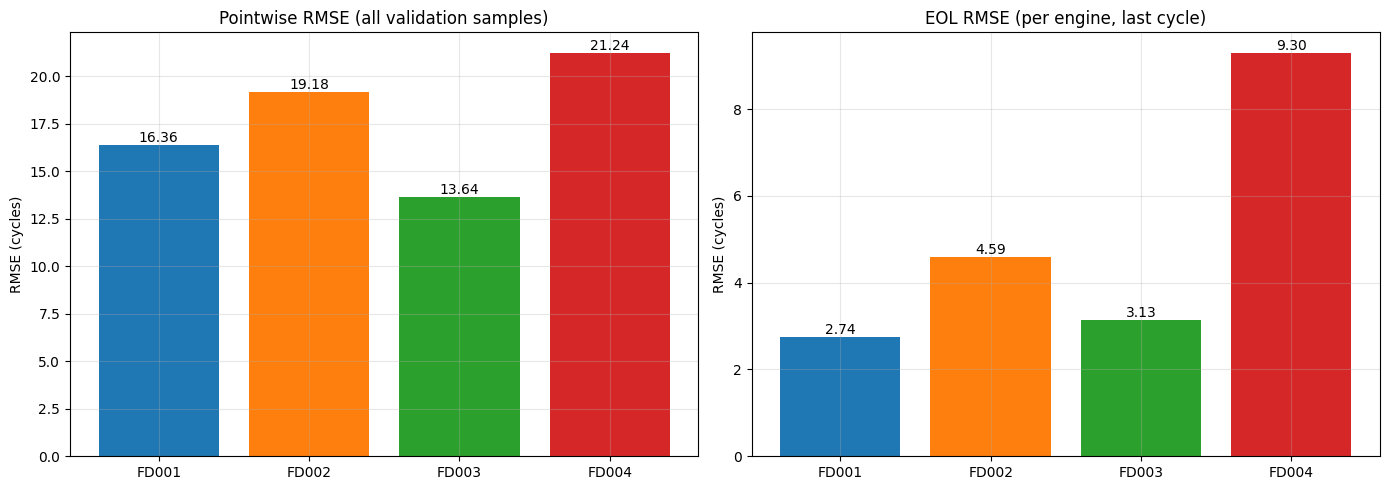

In [10]:
# ===================================================================
# Visualisierung: RMSE Vergleich
# ===================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pointwise RMSE
ax1 = axes[0]
pointwise_rmse = [results_dict[fd]["metrics"]["pointwise"]["rmse"] for fd in FD_DATASETS]
bars1 = ax1.bar(FD_DATASETS, pointwise_rmse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel("RMSE (cycles)")
ax1.set_title("Pointwise RMSE (all validation samples)")
ax1.grid(True, alpha=0.3)
for i, (fd, val) in enumerate(zip(FD_DATASETS, pointwise_rmse)):
    ax1.text(i, val, f"{val:.2f}", ha='center', va='bottom')

# EOL RMSE (falls verfügbar)
ax2 = axes[1]
eol_rmse = []
eol_labels = []
for fd in FD_DATASETS:
    if "eol" in results_dict[fd]["metrics"]:
        eol_rmse.append(results_dict[fd]["metrics"]["eol"]["rmse"])
        eol_labels.append(fd)
    else:
        eol_rmse.append(0)
        eol_labels.append(fd)

if any(eol_rmse):
    bars2 = ax2.bar(eol_labels, eol_rmse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_ylabel("RMSE (cycles)")
    ax2.set_title("EOL RMSE (per engine, last cycle)")
    ax2.grid(True, alpha=0.3)
    for i, (fd, val) in enumerate(zip(eol_labels, eol_rmse)):
        if val > 0:
            ax2.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


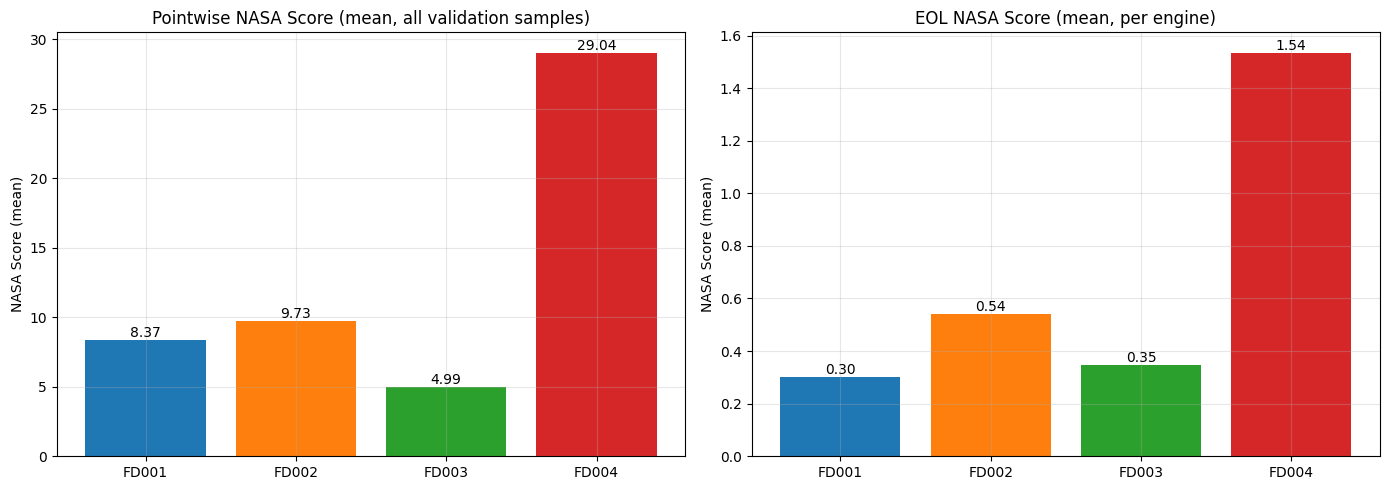

In [11]:
# ===================================================================
# Visualisierung: NASA Score Vergleich
# ===================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pointwise NASA Score (mean)
ax1 = axes[0]
nasa_point_mean = [results_dict[fd]["metrics"]["nasa_pointwise"]["score_mean"] for fd in FD_DATASETS]
bars1 = ax1.bar(FD_DATASETS, nasa_point_mean, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel("NASA Score (mean)")
ax1.set_title("Pointwise NASA Score (mean, all validation samples)")
ax1.grid(True, alpha=0.3)
for i, (fd, val) in enumerate(zip(FD_DATASETS, nasa_point_mean)):
    ax1.text(i, val, f"{val:.2f}", ha='center', va='bottom')

# EOL NASA Score (mean, falls verfügbar)
ax2 = axes[1]
eol_nasa_mean = []
eol_labels = []
for fd in FD_DATASETS:
    if "eol" in results_dict[fd]["metrics"]:
        eol_nasa_mean.append(results_dict[fd]["metrics"]["eol"]["nasa_score_mean"])
        eol_labels.append(fd)
    else:
        eol_nasa_mean.append(0)
        eol_labels.append(fd)

if any(eol_nasa_mean):
    bars2 = ax2.bar(eol_labels, eol_nasa_mean, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_ylabel("NASA Score (mean)")
    ax2.set_title("EOL NASA Score (mean, per engine)")
    ax2.grid(True, alpha=0.3)
    for i, (fd, val) in enumerate(zip(eol_labels, eol_nasa_mean)):
        if val != 0:
            ax2.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [12]:
# ===================================================================
# Zusammenfassung
# ===================================================================
print("\n" + "=" * 80)
print("TRAINING COMPLETE - Summary")
print("=" * 80)
print(f"\nTrained {len(FD_DATASETS)} separate models:")
for fd_id in FD_DATASETS:
    m_point = results_dict[fd_id]["metrics"]["pointwise"]
    print(f"  {fd_id}: RMSE={m_point['rmse']:.4f}, MAE={m_point['mae']:.4f}, R²={m_point['r2']:.4f}")

print("\n" + "=" * 80)
print("All results stored in 'results_dict' dictionary")
print("=" * 80)



TRAINING COMPLETE - Summary

Trained 4 separate models:
  FD001: RMSE=16.3639, MAE=11.8701, R²=0.8454
  FD002: RMSE=19.1763, MAE=14.5185, R²=0.7892
  FD003: RMSE=13.6352, MAE=9.4706, R²=0.8913
  FD004: RMSE=21.2387, MAE=14.9878, R²=0.7356

All results stored in 'results_dict' dictionary
